# Reproducing Figure 4

In this figure, we vary configuration 1 as follows:

* Number of delivery beds: 2 or 3
* Delivery arrivals: 1, 1.5 or 2 per day
    * 1 = IAT 1440 (as in e.g. config1)
    * 1.5 = 960 (as 720+240=960, and 960+480=1440)
    * 2 = IAT 720 (as we did for Figure 3)

## Set up

In [1]:
# To run model
import PHC

# To import results and produce figures
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

# To speed up run time
from multiprocessing import Pool

In [2]:
# Paths to save image files to
output_folder = 'outputs'
fig4_path = os.path.join(output_folder, 'fig4.png')

## Run model

In [3]:
# TODO: Run with 100 replications

# Varying number of childbirth cases
arr_dict = [
    {
        'delivery_iat': 1440,
        'rep_file': 'arr1440'
    },
    {
        'delivery_iat': 960,
        'rep_file': 'arr960'
    },
    {
        'delivery_iat': 720,
        'rep_file': 'arr720'
    }
]

# Varying the number of beds
bed_dict = [
    {
        'delivery_bed_n': 2,
        'rep_file': 'bed2'
    },
    {
        'delivery_bed_n': 3,
        'rep_file': 'bed3'
    }
]

Create each combination for the reproduction

In [4]:
dict_list = []
for arr in arr_dict:
    for bed in bed_dict:
        # Combine the dictionaries
        comb = {**arr, **bed}
        # Replace the file name
        comb['rep_file'] = f'''f4_{arr['rep_file']}_{bed['rep_file']}.xls'''
        # Save to list
        dict_list.append(comb)

len(dict_list)

6

In [5]:
# Append 's_' to all items
for i, d in enumerate(dict_list):
    dict_list[i] = {f's_{k}': v for k, v in d.items()}

# Preview example
dict_list[0]

{'s_delivery_iat': 1440,
 's_rep_file': 'f4_arr1440_bed2.xls',
 's_delivery_bed_n': 2}

Run the model (with parallel processing to reduce run time)

In [6]:
'''
# Wrapper function to allow input of dictionary with pool
def wrapper(d):
    return PHC.main(**d)

# Create a process pool that uses all CPUs
with Pool() as pool:
    # Run PHC.main() using each of inputs from config
    pool.map(wrapper, dict_list)
'''

'\n# Wrapper function to allow input of dictionary with pool\ndef wrapper(d):\n    return PHC.main(**d)\n\n# Create a process pool that uses all CPUs\nwith Pool() as pool:\n    # Run PHC.main() using each of inputs from config\n    pool.map(wrapper, dict_list)\n'

## Process results

In [7]:
def process_results(files):
    '''
    Imports files in provided list and produces a single dataframe with mean
    results from across the replications

    Parameters:
    ----------
    files : list
        List of file names (exc. file type) containing replication results

    Returns:
    --------
    summary : dataframe
        Dataframe with mean results for each model variant in file list
    '''
    # Empty list to store results
    result_list = []

    for f in files:
        # Import .xls and convert to pandas dataframe
        book = xlrd.open_workbook(os.path.join(output_folder, f))
        result = pd.read_excel(book, header=None, index_col=0)

        # Add proportion of childbirth cases referred
        result.loc['prop_del_referred'] = (
            result.loc['del referred'] / result.loc['Del patients'])

        # Find mean from the replication
        # Save as dataframe, dropping the duplicate rows (NCD occ twice)
        res = pd.DataFrame({f: result.mean(axis=1)}).drop_duplicates()

        # Remove index name
        res.index.name = None

        # Remove .xls from column names
        res.columns = res.columns.str.removesuffix('.xls')

        # Save to list
        result_list.append(res)

    # Combine into single dataframe
    summary = pd.concat(result_list, axis=1)

    return summary

In [8]:
data = process_results([i['s_rep_file'] for i in dict_list])
data.head()

,f4_arr1440_bed2,f4_arr1440_bed3,f4_arr960_bed2,f4_arr960_bed3,f4_arr720_bed2,f4_arr720_bed3
OPD patients,33118.600000,33136.00000,33201.200000,33110.100000,33124.600000,33173.100000
IPD patients,178.600000,179.90000,176.700000,180.100000,188.400000,180.900000
ANC patients,371.500000,363.50000,367.300000,361.500000,358.500000,363.000000
Del patients,364.000000,362.00000,540.400000,547.700000,724.800000,738.300000
OPD Q wt,0.009724,0.00824,0.013165,0.016186,0.018377,0.019257


## Create Figure 4

In [9]:
# Select series with proportion referred
a4 = data.loc['prop_del_referred']

# Reshape into appropriate format for plotting
names = ['1', '1.5', '2']
bed2 = [a4['f4_arr1440_bed2'], a4['f4_arr960_bed2'], a4['f4_arr720_bed2']]
bed3 = [a4['f4_arr1440_bed3'], a4['f4_arr960_bed3'], a4['f4_arr720_bed3']]

data_4a = pd.DataFrame({'1 extra bed (total: 2)': bed2,
                        '2 extra beds (total: 3)': bed3}, index=names)
data_4a

,1 extra bed (total: 2),2 extra beds (total: 3)
1,0.018400,0.001385
1.5,0.039399,0.004734
2,0.056695,0.011824


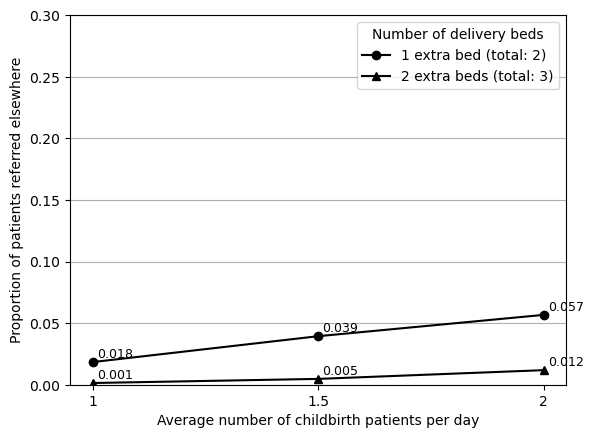

In [10]:
# Plot data
ax = data_4a.plot(kind='line', color='black')

# Add markers
for l, ms in zip(ax.lines, itertools.cycle('o^')):
    l.set_marker(ms)
    l.set_color('black')
ax.legend(title='Number of delivery beds')

# Add labels to each point
for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax.annotate(f'{y:.3f}', xy=(x, y), xytext=(3, 3),
                    textcoords='offset points', fontsize=9)

# Adjust figure
plt.xlabel('Average number of childbirth patients per day')
plt.ylabel('Proportion of patients referred elsewhere')
plt.ylim(0, 0.3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig(fig4_path, bbox_inches='tight')
plt.show()